In [0]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.1.0

# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.1.0")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.1.0, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import stellargraph as sg
from stellargraph import globalvar
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

## Loading the dataset

In [0]:
dataset = datasets.Cora()
graph_full, labels = dataset.load()
#print(graph_full.info())
labels_sampled = labels.sample(frac=0.8, replace=False, random_state=101)
graph_sampled = graph_full.subgraph(labels_sampled.index)
#print(graph_sampled.info())

In [0]:
train_labels, test_labels = model_selection.train_test_split(labels_sampled,train_size=0.05,test_size=None,stratify=labels_sampled,random_state=42)
val_labels, test_labels = model_selection.train_test_split(test_labels, train_size=0.2, test_size=None, stratify=test_labels, random_state=100)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

In [0]:
generator = GraphSAGENodeGenerator(graph_sampled, 50, [10, 10])
train_gen = generator.flow(train_labels.index, train_targets, shuffle=False)

In [0]:
graphsage_model = GraphSAGE(layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5)
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

model = Model(inputs=x_inp, outputs=prediction)
model.compile(optimizer=optimizers.Adam(lr=0.005),loss=losses.categorical_crossentropy,metrics=["acc"])

33/33 [==============================] - 3s 104ms/step - loss: 1.2228 - acc: 0.6709

Test Set Metrics:
	loss: 1.2228
	acc: 0.6709


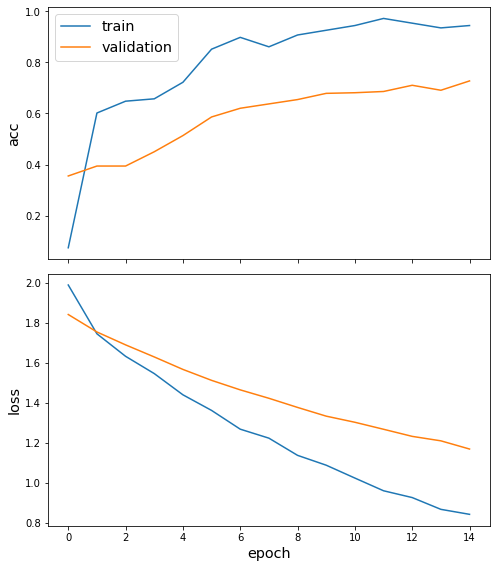

In [6]:
val_gen = generator.flow(val_labels.index, val_targets)
history = model.fit(train_gen, epochs=15, validation_data=val_gen, verbose=0, shuffle=False)
sg.utils.plot_history(history)

test_gen = generator.flow(test_labels.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

# **Evaluate on Removed Nodes**

In [7]:
generator = GraphSAGENodeGenerator(graph_full, 50, [10, 10])
hold_out_nodes = labels.index.difference(labels_sampled.index)
labels_hold_out = labels[hold_out_nodes]

hold_out_targets = target_encoding.transform(labels_hold_out)
hold_out_gen = generator.flow(hold_out_nodes, hold_out_targets)

hold_out_predictions = model.predict(hold_out_gen)
hold_out_predictions = target_encoding.inverse_transform(hold_out_predictions)

hold_out_metrics = model.evaluate(hold_out_gen)
print("\nHold Out Set Metrics:")
for name, val in zip(model.metrics_names, hold_out_metrics):
    print("\t{}: {:0.4f}".format(name, val))

11/11 [==============================] - 1s 58ms/step - loss: 1.2261 - acc: 0.6845

Hold Out Set Metrics:
	loss: 1.2261
	acc: 0.6845


In [0]:
def inference_via_confidence(confidence_mtx1, confidence_mtx2, label_vec1, label_vec2):

    #----------------First step: obtain confidence lists for both training dataset and test dataset--------------
    confidence1 = []
    confidence2 = []
    acc1 = 0
    acc2 = 0
    for num in range(confidence_mtx1.shape[0]):
        confidence1.append(confidence_mtx1[num,label_vec1[num]])
        if np.argmax(confidence_mtx1[num,:]) == np.argmax(label_vec1[num]):
            acc1 += 1

    for num in range(confidence_mtx2.shape[0]):
        confidence2.append(confidence_mtx2[num,label_vec2[num]])
        if np.argmax(confidence_mtx2[num,:]) == np.argmax(label_vec2[num]):
            acc2 += 1
    confidence1 = np.array(confidence1)
    confidence2 = np.array(confidence2)

    print('model accuracy for training and test-', (acc1/confidence_mtx1.shape[0], acc2/confidence_mtx2.shape[0]) )


    #sort_confidence = np.sort(confidence1)
    sort_confidence = np.sort(np.concatenate((confidence1, confidence2)))
    max_accuracy = 0.5
    for num in range(len(sort_confidence)):
        delta = sort_confidence[num]
        ratio1 = np.sum(confidence1>=delta)/confidence_mtx1.shape[0]
        ratio2 = np.sum(confidence2>=delta)/confidence_mtx2.shape[0]
        accuracy_now = 0.5*(ratio1+1-ratio2)
        if accuracy_now > max_accuracy:
            max_accuracy = accuracy_now
    print('maximum inference accuracy is:', max_accuracy)
    return max_accuracy

In [9]:
output_train=model.predict(train_gen)
output_test=model.predict(hold_out_gen)
y_train = train_targets.astype('int')
y_test = hold_out_targets.astype('int')

inference_accuracy=inference_via_confidence(output_train, output_test, y_train, y_test)
print("Maximum Accuracy:",inference_accuracy)


model accuracy for training and test- (0.9722222222222222, 0.6789667896678967)
maximum inference accuracy is: 0.78280032800328
Maximum Accuracy: 0.78280032800328
